## learning-AI101 : topic3_6

In [2]:
# 저번에 만든 개고양이 classification

import os
import tensorflow as tf
import shutil

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../data/dogs-vs-cats/dataset/',
    image_size = (64, 64),
    batch_size = 64, 
    subset = 'training',
    validation_split = 0.2,
    seed = 1234
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../data/dogs-vs-cats/dataset/',
    image_size = (64, 64),
    batch_size = 64, 
    subset = 'validation',
    validation_split = 0.2,
    seed = 1234
)

def 전처리함수(numeric_image, label) : 
    numeric_image = tf.cast(numeric_image/255.0, tf.float32) # 255로 나누어서 0~1 사이의 값으로
    return numeric_image, label
    
train_ds = train_ds.map(전처리함수)
val_ds = val_ds.map(전처리함수)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D( (2, 2) ),
    tf.keras.layers.Dropout(0.2), # 중간에 노드 20% 떨구기
    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D( (2, 2) ),
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D( (2, 2) ),
    tf.keras.layers.Dropout(0.2), # 중간에 노드 20% 떨구기
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"), # 개일 확률, 고양이일 확률
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model.fit (train_ds, validation_data=val_ds, epochs=5)

2024-02-03 14:09:39.409564: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Epoch 1/5
313/313 [==============================] - 44s 134ms/step - loss: 0.6318 - accuracy: 0.6235 - val_loss: 0.5425 - val_accuracy: 0.7320
Epoch 2/5
313/313 [==============================] - 47s 149ms/step - loss: 0.5351 - accuracy: 0.7314 - val_loss: 0.5084 - val_accuracy: 0.7590
Epoch 3/5
313/313 [==============================] - 48s 151ms/step - loss: 0.4837 - accuracy: 0.7653 - val_loss: 0.4578 - val_accuracy: 0.7796
Epoch 4/5
313/313 [==============================] - 47s 149ms/step - loss: 0.4427 - accuracy: 0.7882 - val_loss: 0.4121 - val_accuracy: 0.8142
Epoch 5/5
313/313 [==============================] - 53s 168ms/step - loss: 0.4039 - accuracy: 0.8117 - val_loss: 0.3791 - val_accuracy: 0.8268


-----

**(복습) keras로 인공지능 만드는 순서**
- 1) 모델 만들기
     - layer 만들기
         - activation, node의 갯수, data의 사이즈, 패딩값...
         - 첫번째 레이어는 항상 input_shape 지정, 마지막 레이어 (output layer)의 노드 출력 수 유의
- 2) compile하기
     - loss function, optimizer(learning rate 조절), metrics(보통은 accuracy)
- 3) fit하기
     - train 데이터 넣기, epoch값 지정

그래서 결론적으로 이미지 데이터를 학습시키기 위해선 이미지 데이터 자체를 **수치화**하여 넣는다  
수치화된 이미지 데이터는 사이즈가 중요하다  

근데 역시나 overfitting의 문제가 있기 때문에 같은 이미지더라도 다양한 형태로 집어넣는게 더욱 효율적이다.  

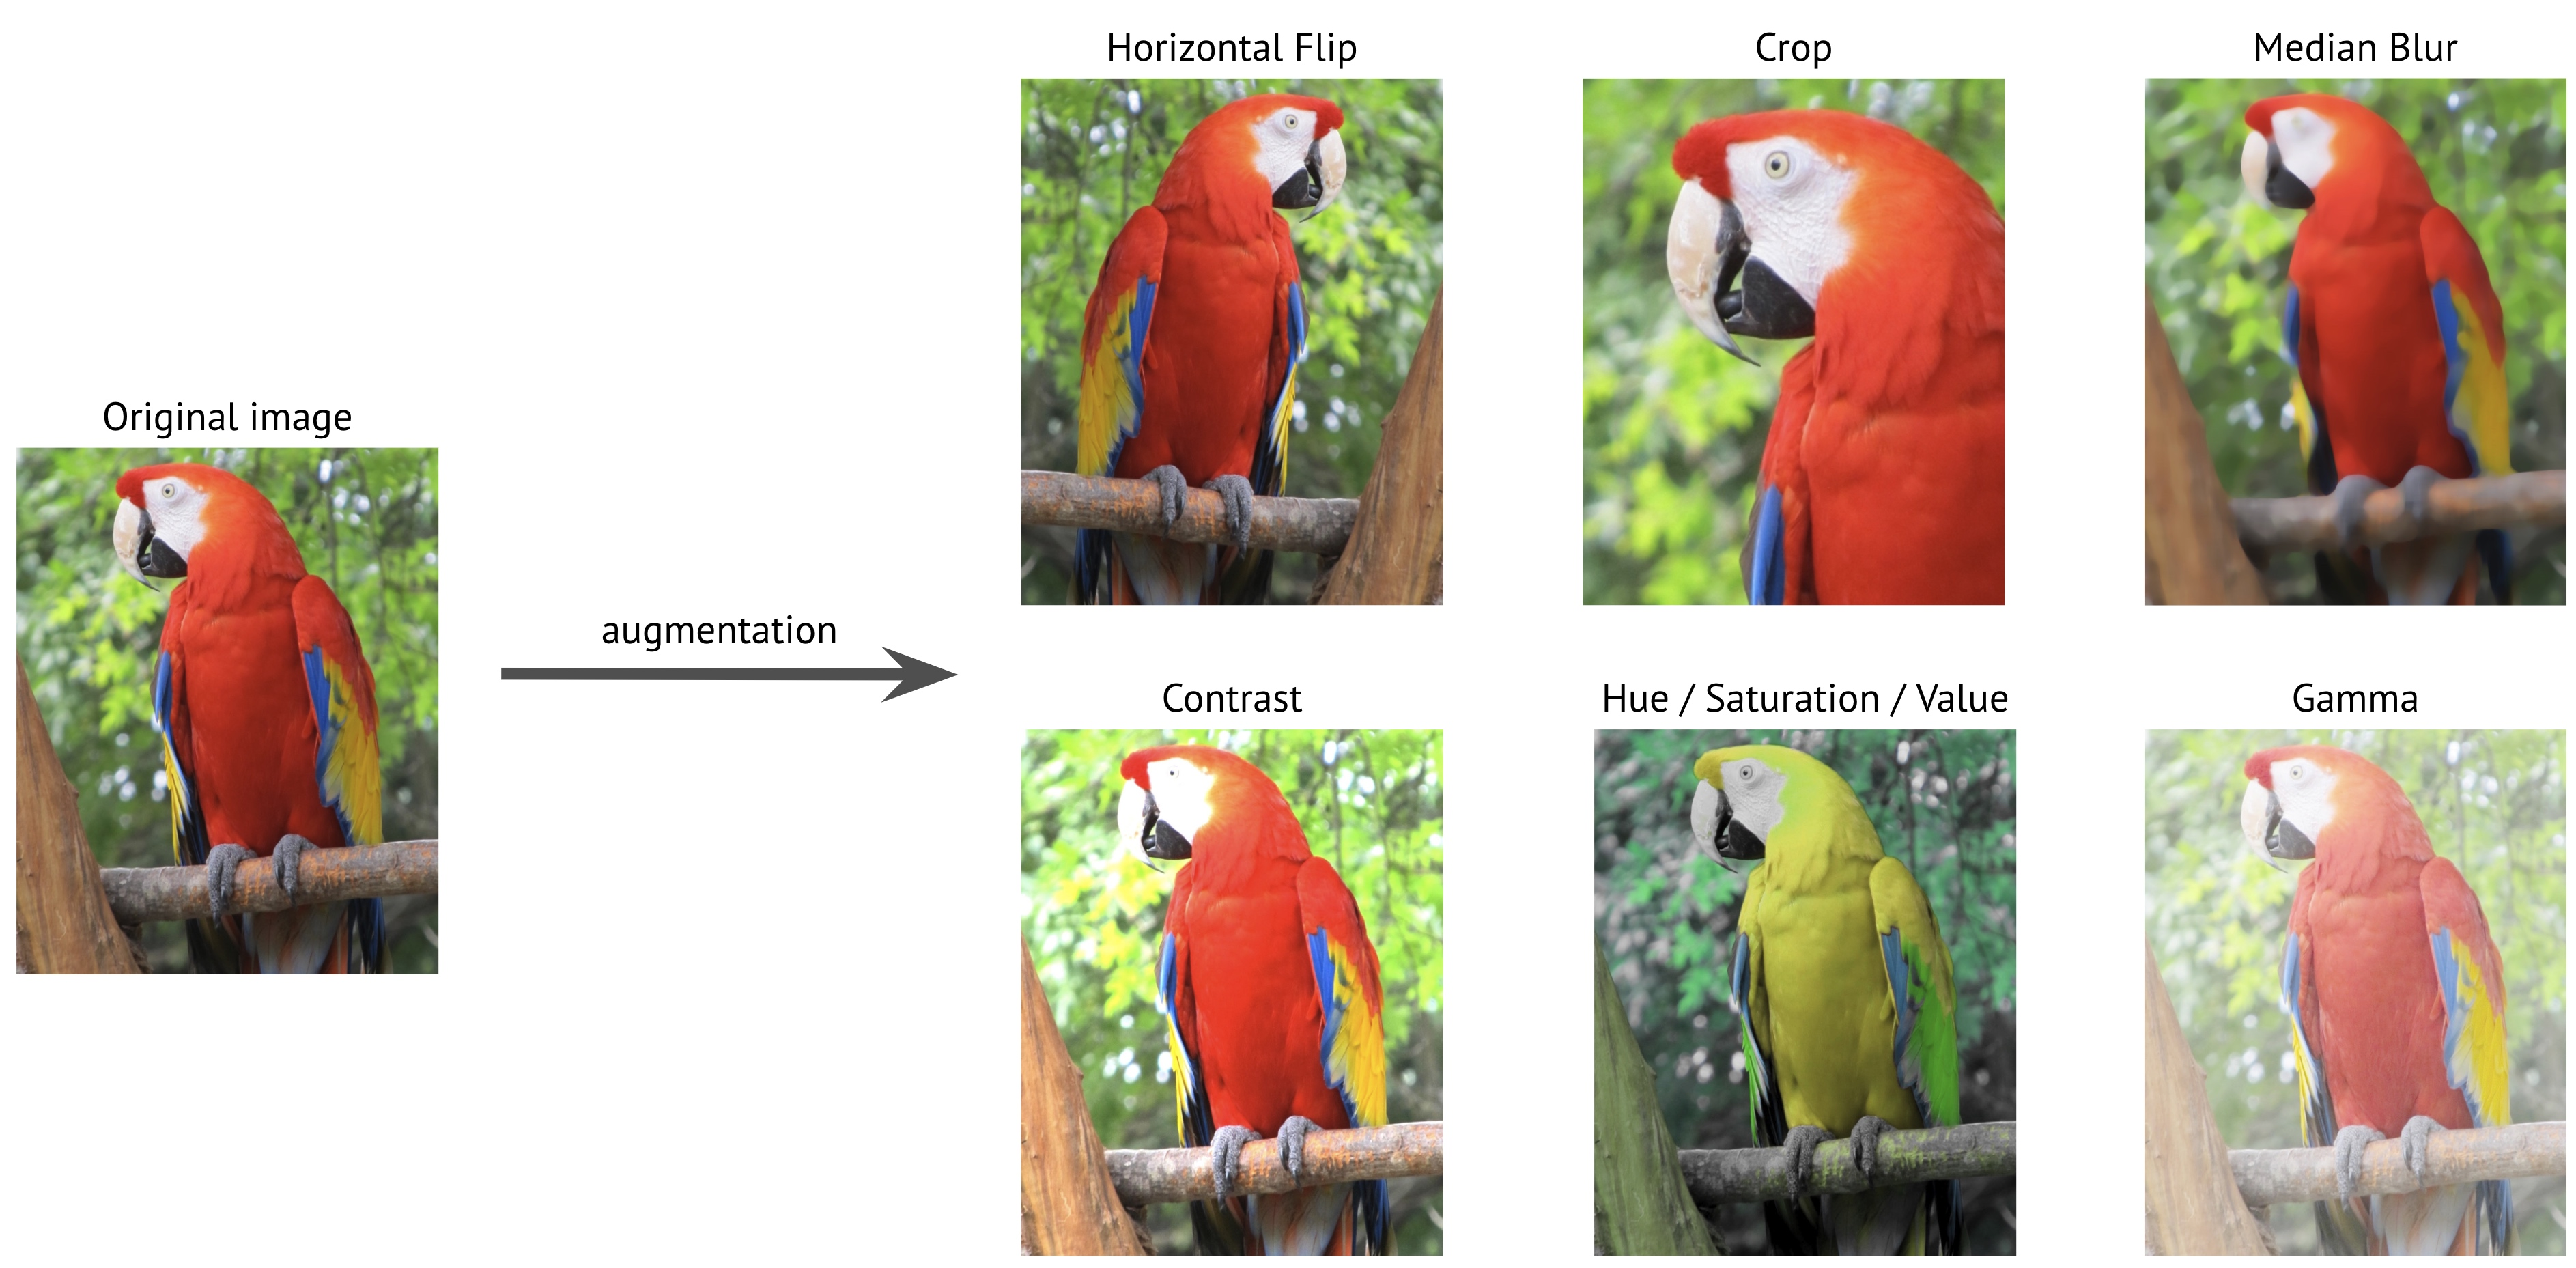  

위와 같이 같은 앵무새 사진이더라도 다양한 형태로 집어넣으면 정확도를 극대화할 수 있다.  
그게 바로 **이미지 증강 (image augmentation)** 이다.

augmentation 방법
- 무식한 방법 : 데이터 사본 생성해서 무지성으로 포토샵으로 흑백사진, 줌아웃사진...
- 똑똑한 방법 : **특정 레이어에 데이터를 넣기 전에 (모델에 데이터를 넣기 전에) 이미지를 증강**  
      - tf.keras.layers.experimental.preprocessing.~~

In [4]:
model = tf.keras.Sequential([
    # 이미지 증강
    # 50%라는 일정한 확률이 있기 때문에, epoch마다 같은 이미지가 아닌 같은 이미지가 변형된 이미지를 학습해서
    # overfitting을 신명나게 막아준다
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(64, 64, 3)), # 가로로뒤집기 (50%확률로)
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1), # 로테이션으로 뒤집기 (50%)
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1), # 줌 (50%)
    ##############################
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D( (2, 2) ),
    tf.keras.layers.Dropout(0.2), # 중간에 노드 20% 떨구기
    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D( (2, 2) ),
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D( (2, 2) ),
    tf.keras.layers.Dropout(0.2), # 중간에 노드 20% 떨구기
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"), # 개일 확률, 고양이일 확률
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_rotation_1 (RandomR  (None, 64, 64, 3)         0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 32)       

In [6]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model.fit (train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
313/313 [==============================] - 55s 167ms/step - loss: 0.5780 - accuracy: 0.6946 - val_loss: 0.6737 - val_accuracy: 0.6544
Epoch 2/5
313/313 [==============================] - 52s 166ms/step - loss: 0.5407 - accuracy: 0.7218 - val_loss: 0.5560 - val_accuracy: 0.7234
Epoch 3/5
313/313 [==============================] - 51s 162ms/step - loss: 0.5198 - accuracy: 0.7414 - val_loss: 0.5265 - val_accuracy: 0.7316
Epoch 4/5
313/313 [==============================] - 49s 155ms/step - loss: 0.5029 - accuracy: 0.7521 - val_loss: 0.4782 - val_accuracy: 0.7724
Epoch 5/5
313/313 [==============================] - 51s 164ms/step - loss: 0.4871 - accuracy: 0.7631 - val_loss: 0.4492 - val_accuracy: 0.7910
